In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import copy
from itertools import permutations, combinations

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

# Functions from 07e* notebooks
import utils_07

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Example computation for 1 task

In [2]:
import copy

tasks = list(utils_07.task_generator())

# Workflow per task from here on.
task = tasks[0]
print(task)
utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)

weights = (
    task.model.state_dict()["module.linear_2.weight"].numpy().tolist()
)
bias: float = float(
    task.model.state_dict()["module.linear_2.bias"].numpy()[0]
)

ONE_VS_NINE__3VRL__auto__0__42


In [3]:
# Get the z-scores
df = pd.DataFrame.from_records(task.z_records)

# Decompose z-scores into 10 columns
df = df.join(pd.DataFrame(df.z.str[0].tolist(), index=df.index))

# Drop col z and rename cols to neuron_0, neuron_1, ...
df = df.drop(columns=["z"]).rename(
    columns={i: f"neuron_{i}" for i in range(10)}
)

# Transform z-scores to activations with Relu for all neuron_i cols
df.set_index("slide", inplace=True)
df = df.applymap(lambda x: max(0, x))

df.head()

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9
slide,,,,,,,,,,
AAHLAWYFDVW,1.192246,1.425897,0.932993,0.000000,3.878773,4.067226,5.519517,0.611165,1.022886,1.630079
AAILLRVFAYW,1.274819,0.000000,0.610554,0.000000,2.323197,2.164732,3.990802,0.353562,0.000000,0.264898
AAIYYGYLFAY,0.000000,0.000000,2.489636,0.000000,4.384460,2.014281,4.598574,0.000000,0.000000,0.000000
AALITPHLFAY,0.000000,0.000000,1.924722,0.000000,2.398535,3.277144,4.153925,0.000000,0.000000,0.000000
AALLWHLPGYF,0.000000,0.000000,0.959236,0.573479,0.659585,1.087988,2.477318,0.112105,0.000000,0.000000


In [4]:
# Get the logits and the others from attributions
df_attr = pd.DataFrame.from_records(task.attributions)
df = pd.merge(
    left=df,
    right=df_attr,
    left_index=True,
    right_on="slide",
)
df.sort_values(by="logits", ascending=False, inplace=True)
df.head()

,neuron_0,neuron_1,neuron_2,neuron_3,neuron_4,neuron_5,neuron_6,neuron_7,neuron_8,neuron_9,slide,logits,expits,y_pred,y_true,is_pred_correct,DeepLIFT_LOCAL_v2.0-2,DeepLIFT_GLOBAL_R10_v2.0-2,exec_time
0,0.438338,4.043356,0.0,1.283342,3.022618,3.080895,3.285594,1.978814,4.330221,0.0,CVRLGWLLHVF,24.884356,1.0,1,1,True,"[[0.0, 2.445488452911377, 0.0, 0.0, -0.2032229...","[[-2.3949785232543945, 2.4764771461486816, -8....",21999.371511
1,0.000000,2.391225,0.0,1.715284,0.776644,1.448458,1.265775,1.743920,3.913634,0.0,CARIPLLLWLL,24.166519,1.0,1,1,True,"[[0.17161640524864197, 1.6042945384979248, 0.0...","[[-1.3717625141143799, 1.988664984703064, -5.9...",21999.371511
2,0.000000,3.007690,0.0,1.534238,3.543389,3.257880,2.863348,1.819012,4.841480,0.0,CARWGLLLYYF,23.560513,1.0,1,1,True,"[[0.0, 2.025603771209717, 0.0, 0.0, -0.2108663...","[[-1.6004047393798828, 2.329777240753174, -7.0...",21999.371511
3,0.000000,2.923327,0.0,1.518090,3.582634,3.541203,2.723644,1.846563,4.910737,0.0,CTRWGLLLYYF,23.481277,1.0,1,1,True,"[[0.0, 1.6169627904891968, 0.0, 0.0, 0.0, 0.19...","[[-1.6277986764907837, 2.0082132816314697, -6....",21999.371511
4,0.117866,3.213465,0.0,1.969347,2.940310,3.122561,2.400430,1.851725,4.259223,0.0,CARIPLLLWYF,23.316917,1.0,1,1,True,"[[0.10894648730754852, 2.0695748329162598, 0.0...","[[-2.3209643363952637, 2.3977439403533936, -7....",21999.371511


Text(0.5, 0, 'Slide ~ logit')

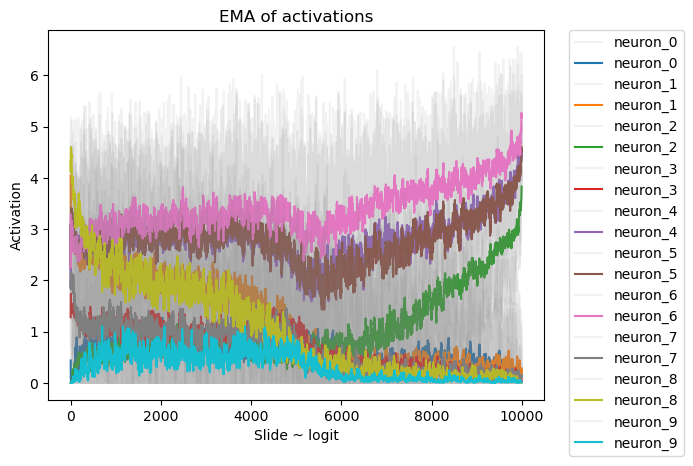

In [5]:
for i in range(10):

    # Compute EMA
    # Plot column without label in legend
    df[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
    ema = df[f"neuron_{i}"].ewm(span=30).mean()
    ema.plot()

# Place legend out of grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("EMA of activations")
plt.ylabel("Activation")
plt.xlabel("Slide ~ logit")

In [6]:
print(weights)

[[1.5767000913619995, 2.3729116916656494, -3.510275363922119, 0.8982719779014587, -0.9353216290473938, -1.1038538217544556, -0.9296962022781372, 2.0140864849090576, 4.325018882751465, 2.3297030925750732]]


# Explore stats across datasets

Consider to explore
- basic stats regarding the w2: #pos, #neg, max neg, skewness over neg/pos
- plot some of them, esp interesting ones. 1v9 vs 1v1 is esp. interesting, but also vs Looser vs vs Non-binder

In [14]:
from scipy.stats import skew

tasks = list(utils_07.task_generator())

records = []
for task in tasks:
    
    print(f"Loading task {task}")
    try:
        utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
    except:
        print(f"Failed to load task {task}")
        continue

    weights = np.array((
        task.model.state_dict()["module.linear_2.weight"].numpy().tolist()
    )[0])
    bias: float = float(
        task.model.state_dict()["module.linear_2.bias"].numpy()[0]
    )

    # Get the z-scores
    df = pd.DataFrame.from_records(task.z_records)

    # Decompose z-scores into 10 columns
    df = df.join(pd.DataFrame(df.z.str[0].tolist(), index=df.index))

    # Drop col z and rename cols to neuron_0, neuron_1, ...
    df = df.drop(columns=["z"]).rename(
        columns={i: f"neuron_{i}" for i in range(10)}
    )

    # Transform z-scores to activations with Relu for all neuron_i cols
    df.set_index("slide", inplace=True)
    df = df.applymap(lambda x: max(0, x))

    # Add data from attributions
    df_attr = pd.DataFrame.from_records(task.attributions)
    df = pd.merge(
        left=df,
        right=df_attr,
        left_index=True,
        right_on="slide",
    )
    df.sort_values(by="logits", ascending=False, inplace=True)
    
    records.append({
        "task": task,
        "w_#pos": (weights > 0).sum(),
        "w_#neg": (weights < 0).sum(),
        "w_avg_pos": weights[weights > 0].mean(),
        "w_avg_neg": weights[weights < 0].mean(),
        "w_skewness_pos": skew(weights[weights > 0]),
        "w_skewness_neg": skew(weights[weights < 0]),
    })

df = pd.DataFrame.from_records(records)
df.to_csv("07g_Activations_stats.csv")
df.head()

Loading task ONE_VS_NINE__3VRL__auto__0__42
Loading task HIGH_VS_95LOW__3VRL__auto__0__42
Loading task HIGH_VS_LOOSER__3VRL__auto__0__42
Loading task ONE_VS_NINE__3VRL__auto__1__42
Loading task HIGH_VS_95LOW__3VRL__auto__1__42
Loading task HIGH_VS_LOOSER__3VRL__auto__1__42
Loading task ONE_VS_NINE__3VRL__auto__2__42
Loading task HIGH_VS_95LOW__3VRL__auto__2__42
Loading task HIGH_VS_LOOSER__3VRL__auto__2__42
Loading task ONE_VS_NINE__3VRL__auto__3__42
Loading task HIGH_VS_95LOW__3VRL__auto__3__42
Loading task HIGH_VS_LOOSER__3VRL__auto__3__42
Loading task ONE_VS_NINE__3VRL__auto__0__0
Loading task HIGH_VS_95LOW__3VRL__auto__0__0
Loading task HIGH_VS_LOOSER__3VRL__auto__0__0
Loading task ONE_VS_NINE__3VRL__auto__0__1
Loading task HIGH_VS_95LOW__3VRL__auto__0__1
Loading task HIGH_VS_LOOSER__3VRL__auto__0__1
Loading task ONE_VS_NINE__3VRL__auto__0__2
Loading task HIGH_VS_95LOW__3VRL__auto__0__2
Loading task HIGH_VS_LOOSER__3VRL__auto__0__2
Loading task ONE_VS_NINE__3VRL__auto__0__3
Loading

,task,w_#pos,w_#neg,w_avg_pos,w_avg_neg,w_skewness_pos,w_skewness_neg
0,ONE_VS_NINE__3VRL__auto__0__42,6,4,2.252782,-1.619787,0.867708,-1.140754
1,HIGH_VS_95LOW__3VRL__auto__0__42,6,4,2.750525,-2.404510,0.733927,-0.641013
2,HIGH_VS_LOOSER__3VRL__auto__0__42,6,4,2.755415,-3.271253,-1.279538,1.006331
3,ONE_VS_NINE__3VRL__auto__1__42,6,4,2.570542,-2.836464,-0.681780,0.100880
4,HIGH_VS_95LOW__3VRL__auto__1__42,6,4,2.818575,-2.680206,-0.484818,-0.544068


In [17]:
task_types = []
ag_pos = []
for task in df["task"].values:
    
    task_types.append(task.task_type.to_str())
    ag_pos.append(task.ag_pos)

df["task_type"] = task_types
df["ag_pos"] = ag_pos

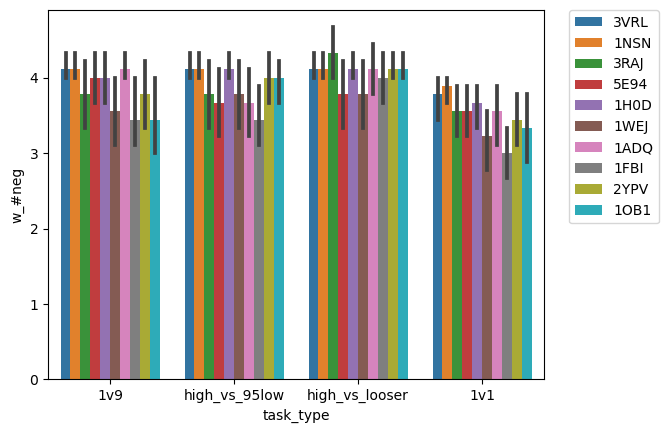

In [19]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_#neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

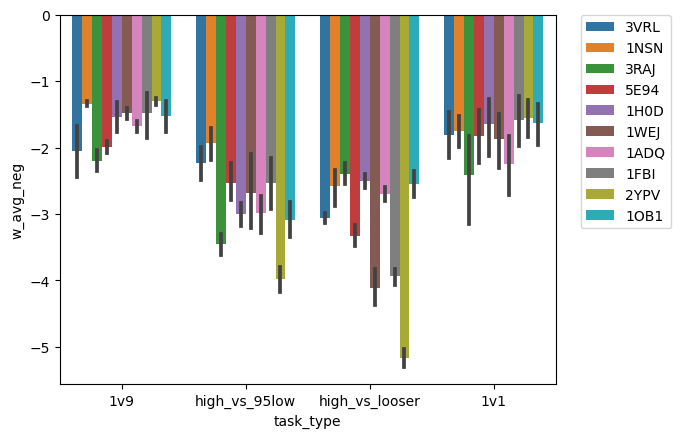

In [20]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_avg_neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

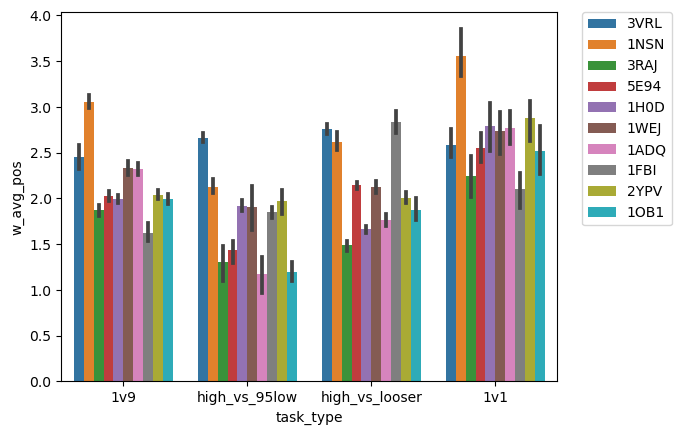

In [21]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_avg_pos",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

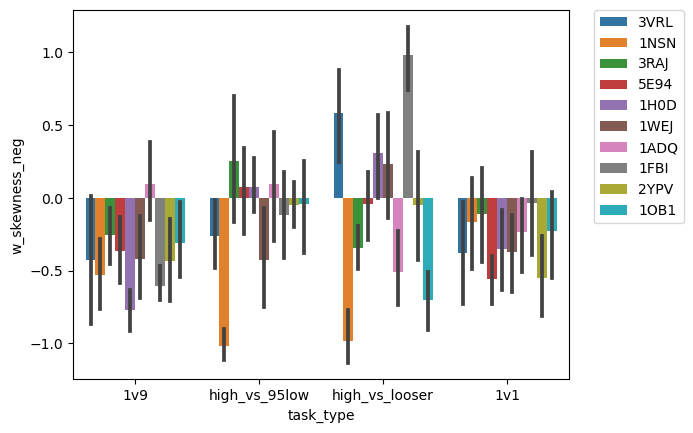

In [22]:
sns.barplot(
    data=df,
    x="task_type",
    y="w_skewness_neg",
    hue="ag_pos",
)

# Legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [23]:
df.query("ag_pos == '2YPV'")

,task,w_#pos,w_#neg,w_avg_pos,w_avg_neg,w_skewness_pos,w_skewness_neg,task_type,ag_pos
216,ONE_VS_NINE__2YPV__auto__0__42,6,4,2.041278,-1.200810,-0.351175,-1.096646,1v9,2YPV
217,HIGH_VS_95LOW__2YPV__auto__0__42,6,4,1.812034,-3.626392,0.998669,-0.008975,high_vs_95low,2YPV
218,HIGH_VS_LOOSER__2YPV__auto__0__42,6,4,1.979986,-5.015902,-0.138718,-0.433999,high_vs_looser,2YPV
219,ONE_VS_NINE__2YPV__auto__1__42,6,4,2.181505,-1.469321,0.736740,0.227053,1v9,2YPV
220,HIGH_VS_95LOW__2YPV__auto__1__42,6,4,2.181976,-4.411359,0.507988,0.234310,high_vs_95low,2YPV
221,HIGH_VS_LOOSER__2YPV__auto__1__42,6,4,1.960489,-5.564366,-0.340332,-0.857134,high_vs_looser,2YPV
222,ONE_VS_NINE__2YPV__auto__2__42,6,4,1.950181,-1.351662,-0.591784,-0.437797,1v9,2YPV
223,HIGH_VS_95LOW__2YPV__auto__2__42,6,4,2.291582,-4.466679,0.258483,-0.442563,high_vs_95low,2YPV
224,HIGH_VS_LOOSER__2YPV__auto__2__42,6,4,1.867802,-5.295259,1.225717,-0.463258,high_vs_looser,2YPV
225,ONE_VS_NINE__2YPV__auto__3__42,5,5,1.974120,-1.318192,-0.562127,-0.177015,1v9,2YPV


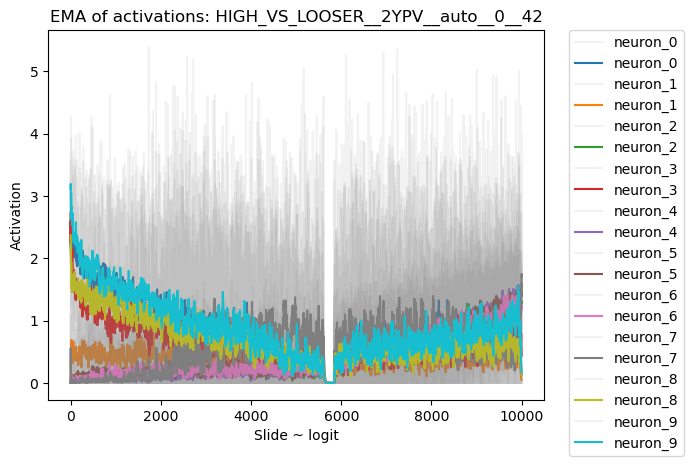

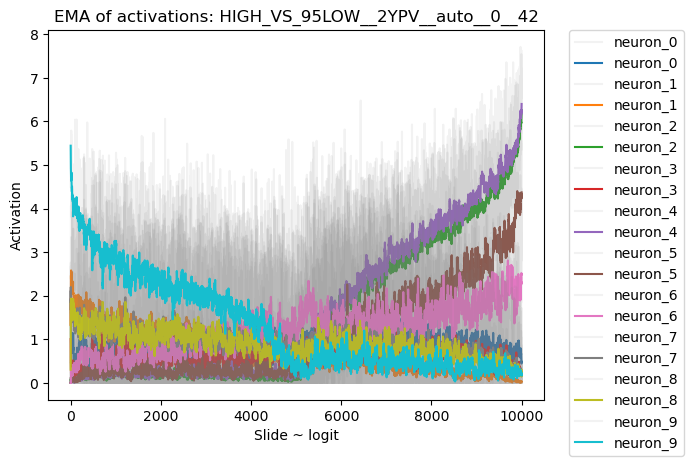

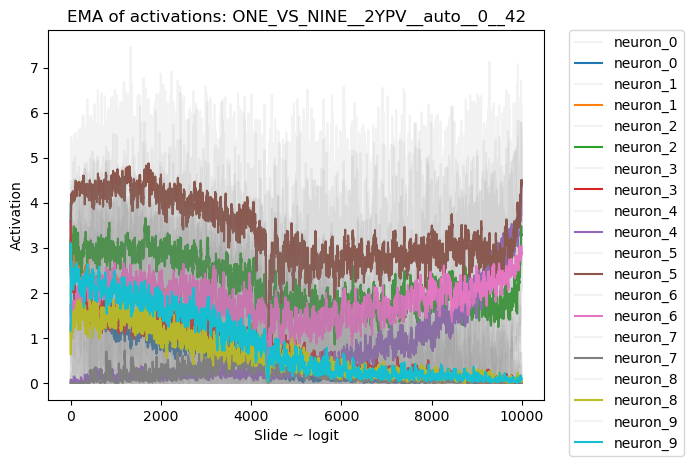

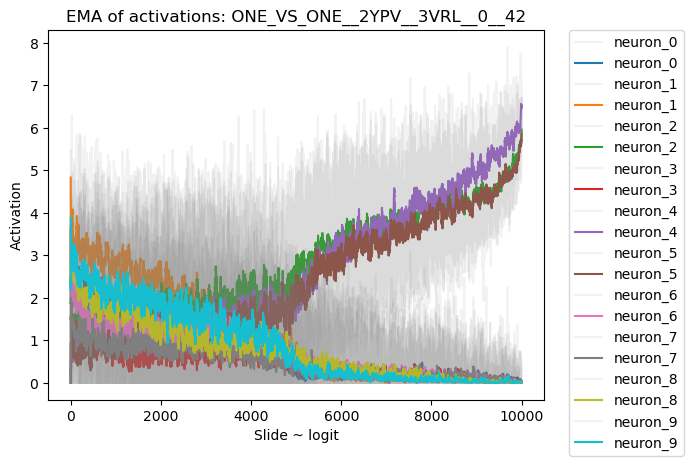

In [29]:
task_strs = [
    "HIGH_VS_LOOSER__2YPV__auto__0__42",
    "HIGH_VS_95LOW__2YPV__auto__0__42",
    "ONE_VS_NINE__2YPV__auto__0__42",
    "ONE_VS_ONE__2YPV__3VRL__0__42",
]

for task_str in task_strs:
    task = datasets.ClassificationTask.init_from_str(task_str)
    utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
    
    # Get the z-scores
    df_i = pd.DataFrame.from_records(task.z_records)

    # Decompose z-scores into 10 columns
    df_i = df_i.join(pd.DataFrame(df_i.z.str[0].tolist(), index=df_i.index))

    # Drop col z and rename cols to neuron_0, neuron_1, ...
    df_i = df_i.drop(columns=["z"]).rename(
        columns={i: f"neuron_{i}" for i in range(10)}
    )

    # Transform z-scores to activations with Relu for all neuron_i cols
    df_i.set_index("slide", inplace=True)
    df_i = df_i.applymap(lambda x: max(0, x))

    # Get the logits and the others from attributions
    df_attr = pd.DataFrame.from_records(task.attributions)
    df_i = pd.merge(
        left=df_i,
        right=df_attr,
        left_index=True,
        right_on="slide",
    )
    df_i.sort_values(by="logits", ascending=False, inplace=True)

    for i in range(10):

        # Compute EMA
        # Plot column without label in legend
        df_i[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
        ema = df_i[f"neuron_{i}"].ewm(span=30).mean()
        ema.plot()

        # Place legend out of grid
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.title(f"EMA of activations: {task_str}")
        plt.ylabel("Activation")
        plt.xlabel("Slide ~ logit")
    plt.show()

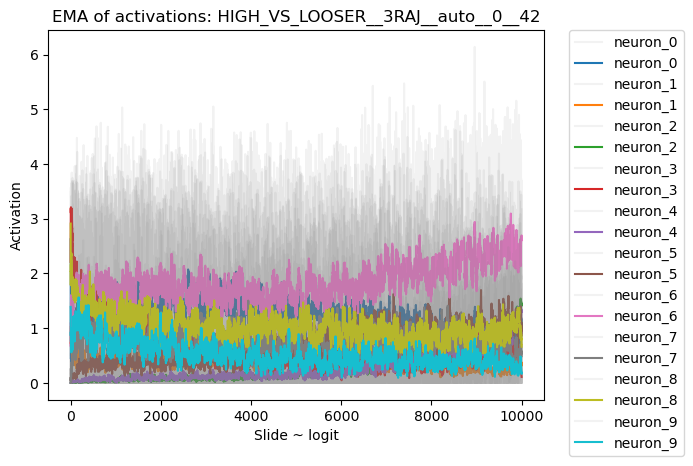

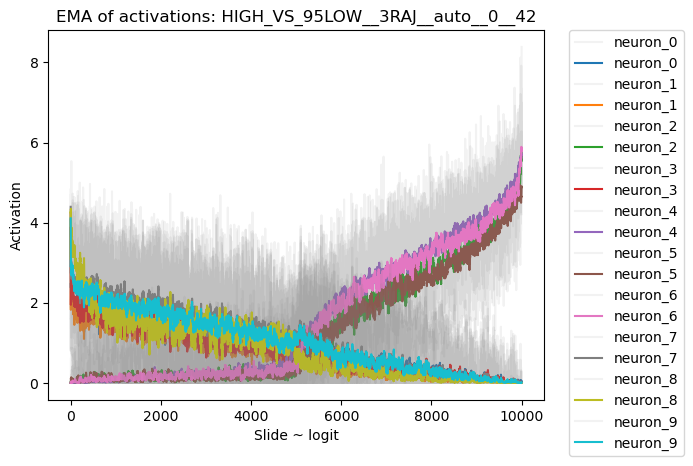

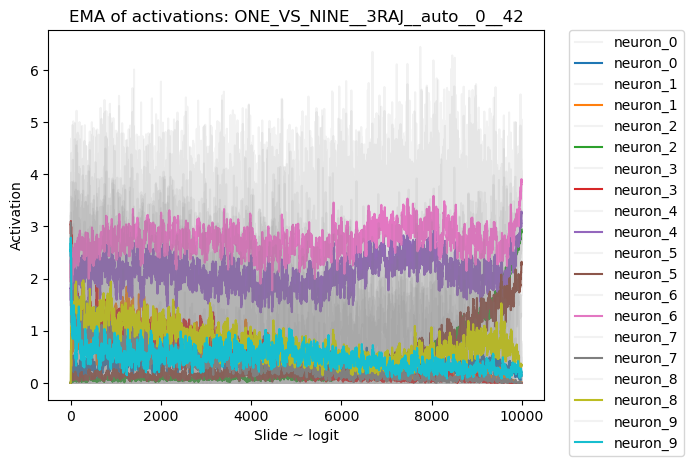

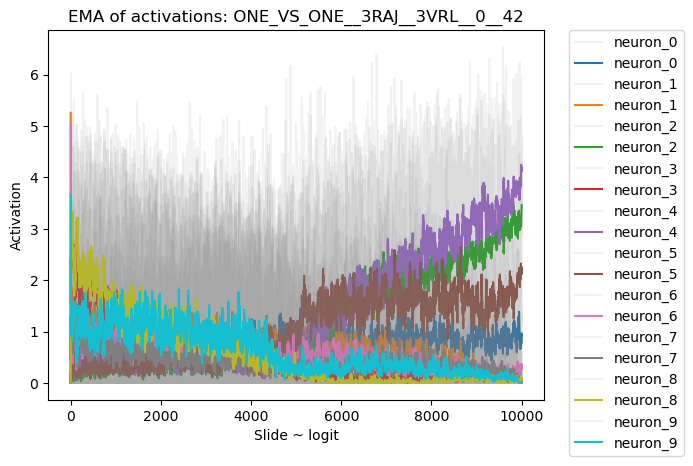

In [30]:
task_strs = [
    "HIGH_VS_LOOSER__3RAJ__auto__0__42",
    "HIGH_VS_95LOW__3RAJ__auto__0__42",
    "ONE_VS_NINE__3RAJ__auto__0__42",
    "ONE_VS_ONE__3RAJ__3VRL__0__42",
]

for task_str in task_strs:
    task = datasets.ClassificationTask.init_from_str(task_str)
    utils_07.loader.load(task, attributions_toload="v2.0-2", load_zscores=True)
    
    # Get the z-scores
    df_i = pd.DataFrame.from_records(task.z_records)

    # Decompose z-scores into 10 columns
    df_i = df_i.join(pd.DataFrame(df_i.z.str[0].tolist(), index=df_i.index))

    # Drop col z and rename cols to neuron_0, neuron_1, ...
    df_i = df_i.drop(columns=["z"]).rename(
        columns={i: f"neuron_{i}" for i in range(10)}
    )

    # Transform z-scores to activations with Relu for all neuron_i cols
    df_i.set_index("slide", inplace=True)
    df_i = df_i.applymap(lambda x: max(0, x))

    # Get the logits and the others from attributions
    df_attr = pd.DataFrame.from_records(task.attributions)
    df_i = pd.merge(
        left=df_i,
        right=df_attr,
        left_index=True,
        right_on="slide",
    )
    df_i.sort_values(by="logits", ascending=False, inplace=True)

    for i in range(10):

        # Compute EMA
        # Plot column without label in legend
        df_i[f"neuron_{i}"].plot(alpha=0.1, label=None, color="gray")
        ema = df_i[f"neuron_{i}"].ewm(span=30).mean()
        ema.plot()

        # Place legend out of grid
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.title(f"EMA of activations: {task_str}")
        plt.ylabel("Activation")
        plt.xlabel("Slide ~ logit")
    plt.show()